In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import os
import PIL
import PIL.Image
import pathlib
from sklearn.model_selection import train_test_split
data_dir = pathlib.Path("/Users/Davran/0_Deep_Learning_Project/Insulator Inspection/Insulator")
data_dir_train = pathlib.Path("/Users/Davran/0_Deep_Learning_Project/Insulator Inspection/Insulator/All/*/*")
#data_dir_test = pathlib.Path("C:/Users/Davran/0_Deep_Learning_Project/Implant Inspection/test/*/*")

In [3]:
filenames = tf.io.gfile.glob(str(data_dir_train))
#filenames.extend(tf.io.gfile.glob(str(data_dir_test)))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [4]:
COUNT_CLEAN = len([filename for filename in filenames if "Clean" in filename])
print("Clean images count in training set: " + str(COUNT_CLEAN))

COUNT_POLLUTED = len([filename for filename in filenames if "Polluted" in filename])
print("Polluted images count in training set: " + str(COUNT_POLLUTED))

Clean images count in training set: 70
Polluted images count in training set: 200


In [5]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\20180320_123155.jpg'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\DSCF0118.JPG'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\20200617_124505.jpg'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Polluted\\DSCF0093.JPG'
b'\\Users\\Davran\\0_Deep_Learning_Project\\Insulator Inspection\\Insulator\\All\\Clean\\20200617_123535.jpg'


In [6]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Train images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validation images count: " + str(VAL_IMG_COUNT))

Train images count: 216
Validation images count: 54


In [7]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(data_dir) + "/All/*")])
CLASS_NAMES

array(['Clean', 'Polluted'], dtype='<U8')

In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == 'Clean':
        return 0
    else:
        return 1

In [9]:
def decode_img(img):
    # convert the compressed string
    img_X = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img_X = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(img_X)
    #img_X = tf.image.convert_image_dtype(img_X, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img_X, IMAGE_SIZE)

In [10]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = (224, 224)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
X_train = []
y_train = []

for image, label in train_ds:
    X_train.append(image)
    y_train.append(label)    
X_train = np.array(X_train, dtype = 'float32')
y_train = np.array(y_train, dtype = 'int8')

shuffled_idx = np.random.permutation(TRAIN_IMG_COUNT)
X_train[:] = X_train[shuffled_idx]
y_train[:] = y_train[shuffled_idx]
print(X_train.shape)
print(y_train.shape)

(216, 224, 224, 3)
(216,)


In [13]:
X_val = []
y_val = []

for image, label in val_ds:
    X_val.append(image)
    y_val.append(label)    
X_val = np.array(X_val, dtype = 'float32')
y_val = np.array(y_val, dtype = 'int8')

shuffled_idx = np.random.permutation(VAL_IMG_COUNT)
X_val[:] = X_val[shuffled_idx]
y_val[:] = y_val[shuffled_idx]
print(X_val.shape)
print(y_val.shape)

(54, 224, 224, 3)
(54,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


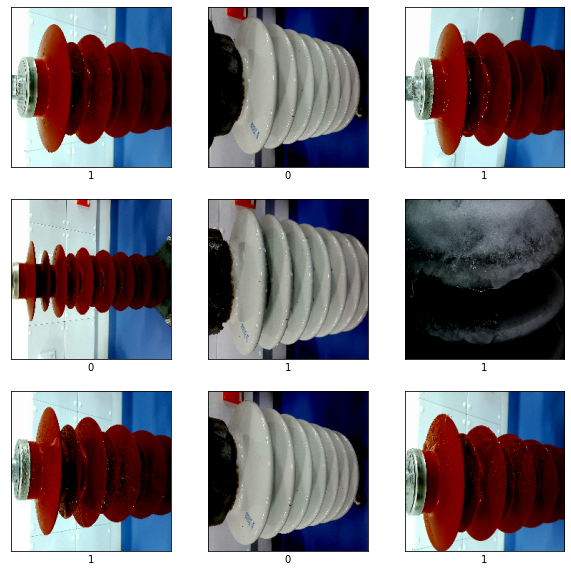

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(y_train[i])
    
# The figure below shows the downsampled images of insulators with the labels below.

In [15]:
IMG_SHAPE = IMAGE_SIZE + (3, )
IMG_SHAPE

(224, 224, 3)

In [16]:
base_model = tf.keras.applications.Xception(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

In [17]:
#image_batch, label_batch = next(iter(X_train))
feature_batch = base_model(X_train)
print(feature_batch.shape)

(216, 7, 7, 2048)


In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [20]:
base_model.save('base_model_Xception')

INFO:tensorflow:Assets written to: base_model_Xception\assets


C:\Users\Davran\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Davran\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [21]:
stop

NameError: name 'stop' is not defined

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(216, 2048)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(216, 1)


In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_____________________________________________

In [27]:
len(model.trainable_variables)

2

In [28]:
type(X_val)

numpy.ndarray

In [29]:
tf.config.run_functions_eagerly(True)

In [30]:
initial_epochs = 150

loss0, accuracy0 = model.evaluate(X_val, y_val)

C:\Users\Davran\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 1s 150ms/step - loss: 1.6593 - accuracy: 0.3704


In [31]:
history = model.fit(X_train,
                    y_train,
                    epochs=initial_epochs,
                    validation_data = (X_val, y_val)
                    )

Epoch 1/150
7/7 [==============================] - 9s 289ms/step - loss: 2.5203 - accuracy: 0.4583 - val_loss: 2.0877 - val_accuracy: 0.6111
Epoch 2/150
7/7 [==============================] - 2s 240ms/step - loss: 1.9122 - accuracy: 0.5370 - val_loss: 1.3552 - val_accuracy: 0.5185
Epoch 3/150
7/7 [==============================] - 2s 238ms/step - loss: 1.9037 - accuracy: 0.5000 - val_loss: 1.0853 - val_accuracy: 0.5185
Epoch 4/150
7/7 [==============================] - 2s 242ms/step - loss: 1.7112 - accuracy: 0.4861 - val_loss: 1.0594 - val_accuracy: 0.5370
Epoch 5/150
7/7 [==============================] - 2s 258ms/step - loss: 1.8035 - accuracy: 0.5139 - val_loss: 1.0340 - val_accuracy: 0.5185
Epoch 6/150
7/7 [==============================] - 2s 247ms/step - loss: 1.7289 - accuracy: 0.5046 - val_loss: 1.0180 - val_accuracy: 0.5185
Epoch 7/150
7/7 [==============================] - 2s 244ms/step - loss: 1.6691 - accuracy: 0.5602 - val_loss: 1.0043 - val_accuracy: 0.5185
Epoch 8/150
7

Epoch 59/150
7/7 [==============================] - 2s 241ms/step - loss: 1.3816 - accuracy: 0.7037 - val_loss: 0.4112 - val_accuracy: 0.8148
Epoch 60/150
7/7 [==============================] - 2s 251ms/step - loss: 1.3185 - accuracy: 0.6574 - val_loss: 0.4051 - val_accuracy: 0.8148
Epoch 61/150
7/7 [==============================] - 2s 242ms/step - loss: 1.1792 - accuracy: 0.7130 - val_loss: 0.4029 - val_accuracy: 0.8333
Epoch 62/150
7/7 [==============================] - 2s 242ms/step - loss: 0.8956 - accuracy: 0.7083 - val_loss: 0.4015 - val_accuracy: 0.8333
Epoch 63/150
7/7 [==============================] - 2s 243ms/step - loss: 1.1453 - accuracy: 0.6852 - val_loss: 0.3995 - val_accuracy: 0.8148
Epoch 64/150
7/7 [==============================] - 2s 243ms/step - loss: 0.8954 - accuracy: 0.7083 - val_loss: 0.3956 - val_accuracy: 0.8148
Epoch 65/150
7/7 [==============================] - 2s 247ms/step - loss: 1.3008 - accuracy: 0.7130 - val_loss: 0.3918 - val_accuracy: 0.8333
Epoch 

7/7 [==============================] - 2s 243ms/step - loss: 0.8839 - accuracy: 0.8009 - val_loss: 0.3621 - val_accuracy: 0.7963
Epoch 117/150
7/7 [==============================] - 2s 244ms/step - loss: 0.8340 - accuracy: 0.7731 - val_loss: 0.3569 - val_accuracy: 0.8333
Epoch 118/150
7/7 [==============================] - 2s 244ms/step - loss: 0.8339 - accuracy: 0.7917 - val_loss: 0.3536 - val_accuracy: 0.8148
Epoch 119/150
7/7 [==============================] - 2s 244ms/step - loss: 0.8490 - accuracy: 0.7731 - val_loss: 0.3505 - val_accuracy: 0.8148
Epoch 120/150
7/7 [==============================] - 2s 244ms/step - loss: 1.1452 - accuracy: 0.7269 - val_loss: 0.3482 - val_accuracy: 0.8148
Epoch 121/150
7/7 [==============================] - 2s 243ms/step - loss: 0.7932 - accuracy: 0.7917 - val_loss: 0.3466 - val_accuracy: 0.8148
Epoch 122/150
7/7 [==============================] - 2s 244ms/step - loss: 0.8873 - accuracy: 0.7731 - val_loss: 0.3487 - val_accuracy: 0.8333
Epoch 123/150

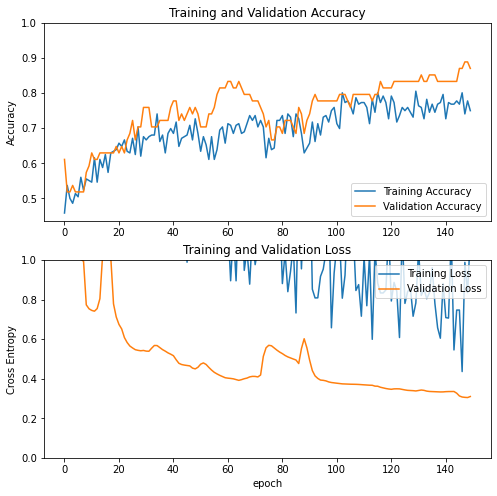

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()